# Example Game with a Custom Player

We play a single game using built-in players and one custom player and then try to figure out which one has the best strategy in the long run.

All the imports are centralized in the cell below.

In [1]:
from maverick import (
    Game,
    Player,
    ActionType,
    GameState,
    Street,
    PlayerLike,
    PlayerAction,
    PlayerState,
)
from maverick.players import FoldBot, CallBot, AggressiveBot
import logging
from functools import partial
import matplotlib.pyplot as plt

## Custom Players

In [2]:
class CustomBot(Player):
    """A custom implementation of a player bot."""

    def decide_action(
        self,
        game: Game,
        valid_actions: list[ActionType],
        min_raise: int
    ) -> PlayerAction:
        # Simple strategy: aggressive early, cautious later
        pot_size = game.state.pot

        # On pre-flop, be selective
        if game.state.street == Street.PRE_FLOP:
            if ActionType.CHECK in valid_actions:
                return PlayerAction(player_id=self.id, action_type=ActionType.CHECK)
            elif ActionType.CALL in valid_actions:
                call_amount = game.state.current_bet - self.state.current_bet
                # Only call small bets pre-flop
                if call_amount <= game.state.big_blind * 3:
                    if call_amount <= self.state.stack:
                        return PlayerAction(player_id=self.id, action_type=ActionType.CALL, amount=call_amount)
            return PlayerAction(player_id=self.id, action_type=ActionType.FOLD)

        # Post-flop, consider pot size
        if ActionType.BET in valid_actions and pot_size < game.state.big_blind * 10:
            bet_amount = pot_size // 2
            if bet_amount <= self.state.stack and bet_amount >= game.state.min_bet:
                return PlayerAction(player_id=self.id, action_type=ActionType.BET, amount=bet_amount)

        if ActionType.CHECK in valid_actions:
            return PlayerAction(player_id=self.id, action_type=ActionType.CHECK)

        if ActionType.CALL in valid_actions:
            call_amount = game.state.current_bet - self.state.current_bet
            # Use pot odds to decide
            if call_amount <= pot_size // 3 and call_amount <= self.state.stack:
                return PlayerAction(player_id=self.id, action_type=ActionType.CALL, amount=call_amount)

        return PlayerAction(player_id=self.id, action_type=ActionType.FOLD)

## Play a Single Game

In [3]:
# Configure logging such that we only get the log messages of the game
logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
)
logging.getLogger().setLevel(logging.WARNING)  # Set root logger to WARNING
logging.getLogger("maverick").setLevel(logging.DEBUG)  # Only maverick logs at DEBUG

# Create game with blinds
game = Game(small_blind=10, big_blind=20, max_hands=40)

# Create and add players with different strategies
players: list[PlayerLike] = [
    CallBot(id="p1", name="CallBot", state=PlayerState(stack=1000, seat=0)),
    AggressiveBot(id="p2", name="AggroBot", state=PlayerState(stack=1000, seat=1)),
    CustomBot(id="p3", name="CustomBot", state=PlayerState(stack=1000, seat=2)),
    FoldBot(id="p4", name="FoldBot", state=PlayerState(stack=1000, seat=3)),
]

for player in players:
    game.add_player(player)
    
game.start()

2026-01-10 19:37:20,552 [INFO] maverick: Player CallBot joined the game.
2026-01-10 19:37:20,552 [INFO] maverick: Player AggroBot joined the game.
2026-01-10 19:37:20,552 [INFO] maverick: Player CustomBot joined the game.
2026-01-10 19:37:20,553 [INFO] maverick: Player FoldBot joined the game.
2026-01-10 19:37:20,553 [INFO] maverick: Game started.

2026-01-10 19:37:20,553 [INFO] maverick: ============================== Hand 1 ==============================

2026-01-10 19:37:20,554 [INFO] maverick: PRE_FLOP | Dealing hole cards. Button: CallBot
2026-01-10 19:37:20,554 [INFO] maverick: PRE_FLOP | Posting small blind of 10 by player AggroBot. Remaining stack: 990
2026-01-10 19:37:20,554 [INFO] maverick: PRE_FLOP | Posting big blind of 20 by player CustomBot. Remaining stack: 980
2026-01-10 19:37:20,555 [INFO] maverick: PRE_FLOP | Player FoldBot folds.
2026-01-10 19:37:20,555 [INFO] maverick: PRE_FLOP | Current pot: 30
2026-01-10 19:37:20,555 [INFO] maverick: PRE_FLOP | Player CallBot call

You can print the final stacks of the players using the original list of players:

In [4]:
for player in players:
    print(f"{player.name} - Stack: {player.state.stack}")

CallBot - Stack: 2100
AggroBot - Stack: 1260
CustomBot - Stack: 0
FoldBot - Stack: 640


You can also use the state for this, but be aware that it only includes players who actually have some stack. If a player got eliminated, it wont apper in the following listing.

In [5]:
for player in game.state.players:
    print(f"{player.name} - Stack: {player.state.stack}")

CallBot - Stack: 2100
AggroBot - Stack: 1260
FoldBot - Stack: 640


## Find the best player

We are going to find the best player by playing lots of games with the same players as before and calculating their average payoff.

For this, we first need to wrap up the game in a function that we can call in a loop.

In [6]:
# We don't want too much logging output for this example
logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
)
logging.getLogger().setLevel(logging.WARNING)
logging.getLogger("maverick").setLevel(logging.WARNING)


# Function to play a game with specified parameters
def play_game(
    small_blind:int=10, 
    big_blind:int=20, 
    max_hands:int=40,
    initial_stack:int=1000
) -> tuple[list[PlayerLike],Game]:
    game = Game(small_blind=small_blind, big_blind=big_blind, max_hands=max_hands)

    players: list[PlayerLike] = [
        CallBot(id="p1", name="CallBot", state=PlayerState(stack=initial_stack, seat=0)),
        AggressiveBot(id="p2", name="AggroBot", state=PlayerState(stack=initial_stack, seat=1)),
        CustomBot(id="p3", name="CustomBot", state=PlayerState(stack=initial_stack, seat=2)),
        FoldBot(id="p4", name="FoldBot", state=PlayerState(stack=initial_stack, seat=3)),
    ]

    for player in players:
        game.add_player(player)
        
    game.start()
    
    return players, game


# Test by playing a single game and printing the final stacks
players, game = play_game(small_blind=10, big_blind=20, max_hands=10, initial_stack=1000)
for player in players:
    print(f"{player.name} - Stack: {player.state.stack}")

CallBot - Stack: 870
AggroBot - Stack: 1840
CustomBot - Stack: 370
FoldBot - Stack: 920


Now play a bunch of games and visualize average payoffs. Here we define payoff as the final stock minus the initial stack. This means that the payoff can be negative. The reason behind this choice is that this gives a more intuitive visual representation (look at the FoldBot).

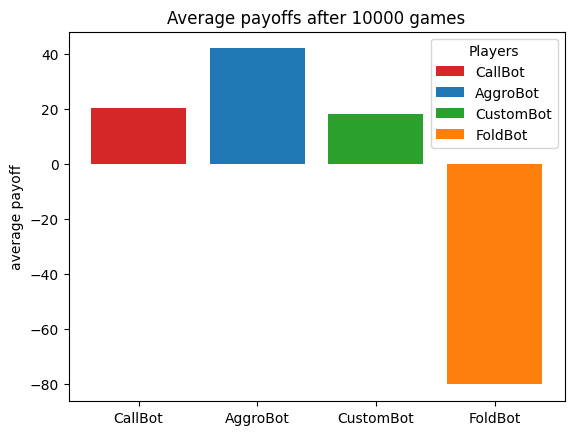

In [7]:
# Start with a smaller number (like 100) to get a feel of execution time,
# then you can move to higher numbers like 10_000 for a more confident estimation.
n_game = 10_000

# Define game parameters
small_blind = 10
big_blind = 20
max_hands = 10         # limit the number of hands per game
initial_stack = 1000

# Create helper function with fixed parameters
play = partial(
    play_game, 
    small_blind=small_blind, 
    big_blind=big_blind, 
    max_hands=max_hands, 
    initial_stack=initial_stack
)

# Collect results
results = {p.name : [] for p in players}
for _ in range(n_game):
    players, game = play()
    for player in players:
        results[player.name].append(player.state.stack - initial_stack)

# Compute average payoffs    
average_payoffs = {name: sum(payoffs)/n_game for name, payoffs in results.items()}

# --------------------------------- Plotting ---------------------------------

fig, ax = plt.subplots()

names = []
avg_payoffs = []
for name, avg_payoff in average_payoffs.items():
    names.append(name)
    avg_payoffs.append(avg_payoff)
    
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']
ax.bar(names, avg_payoffs, label=names, color=bar_colors)

ax.set_ylabel('average payoff')
ax.set_title(f'Average payoffs after {n_game} games')
ax.legend(title='Players')

plt.show()

### Findings

Here are my findings about kicking off the previous cell a number of times with 10_000 experiments:

1) CustomBot's strategy is weak on average.
2) AggroBot is typically the best performer among these players.
3) CallBot probably beats CustomBot in the long run.
4) As expected, the strategy of FoldBot leads to no good.